In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
RANDOM_SEED = 42

In [3]:
df = pd.read_csv('../input/umatech2019competiton/images_labelling.csv')
df.head()

,boxid,label,class_
0,40498,1,B48
1,24303,1,B48
2,48328,1,B48
3,13981,1,B48
4,19874,1,B48


In [4]:
df['label'].value_counts()

23    150
22    150
2     150
4     150
6     150
8     150
10    150
12    150
14    150
16    150
18    150
20    150
24    150
21    150
1     150
3     150
5     150
7     150
9     150
11    150
13    150
15    150
17    150
19    150
0     150
Name: label, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
y = df['label']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

In [7]:
df.drop(labels=['label'], axis=1, inplace=True)
df.head()

,boxid,class_
0,40498,B48
1,24303,B48
2,48328,B48
3,13981,B48
4,19874,B48


In [8]:
X = df
X.head()

,boxid,class_
0,40498,B48
1,24303,B48
2,48328,B48
3,13981,B48
4,19874,B48


In [9]:
X_train, X_test, y_train, y_test = train_test_split(\
                                                    X, y,\
                                                    test_size = 0.20, shuffle=True,\
                                                    stratify = y, random_state=RANDOM_SEED)

In [10]:
y_train.value_counts()


23    120
22    120
2     120
4     120
6     120
8     120
10    120
12    120
14    120
16    120
18    120
20    120
24    120
21    120
1     120
3     120
5     120
7     120
9     120
11    120
13    120
15    120
17    120
19    120
0     120
Name: label, dtype: int64

In [11]:
y_test.value_counts()

24    30
11    30
1     30
2     30
3     30
4     30
5     30
6     30
7     30
8     30
9     30
10    30
12    30
23    30
13    30
14    30
15    30
16    30
17    30
18    30
19    30
20    30
21    30
22    30
0     30
Name: label, dtype: int64

In [12]:
train_df = X_train.join(y_train)
train_df.head()

,boxid,class_,label
3678,2423,B1,3
3203,17290,A31,23
3204,53594,A31,23
2051,20629,A19,16
2790,39303,A33,18


In [13]:
test_df = X_test.join(y_test)
test_df.head()

,boxid,class_,label
1974,26910,A19,16
913,2551,B8,11
3141,42455,B44,22
102,16261,B48,1
3464,60925,A8,7


In [14]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
from PIL import Image
from torchvision import transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

import random
import shutil 
import cv2
from tqdm import tqdm

In [15]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

In [16]:
filepath = '../input/umatech2019competiton/'
class ImagesDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform = None,
                 loader = torchvision.datasets.folder.default_loader):
        self.df = df
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        row = self.df.iloc[index]
        target = row['label']
        path = filepath + str(row['boxid']) + '.png'
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

    def __len__(self):
        n, _ = self.df.shape
        return n

In [17]:
# what transformations should be done with our images
train_transforms = transforms.Compose([
#     transforms.RandomAffine(degrees=15, scale=(1.1, 1.3)),
#    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
#    transforms.Grayscale(3),
    transforms.CenterCrop(40),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
#    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
#    transforms.Grayscale(3),
    transforms.CenterCrop(40),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [18]:
# initialize our dataset at first
dataset = ImagesDataset(
    df = train_df,
    transform = train_transforms
)

batch_size = 16
validation_split = 0.2
shuffle_dataset = True
# Creating data indices for training and validation splits:
dataset_size = len(train_df)

indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, 
                                           sampler = train_sampler)
val_dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size,
                                                sampler = valid_sampler)

In [19]:
len(train_dataloader), len(train_indices)

(150, 2400)

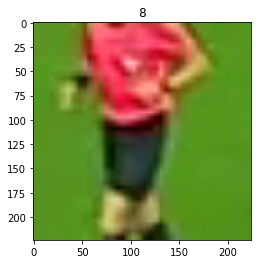

In [20]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);
plt.title(int(y_batch[0]))
plt.show()

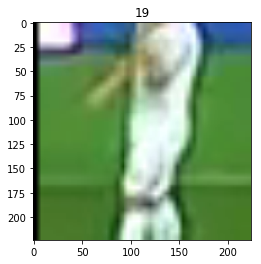

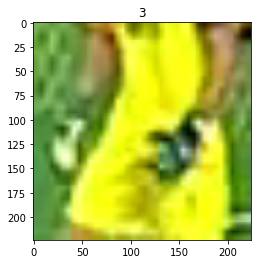

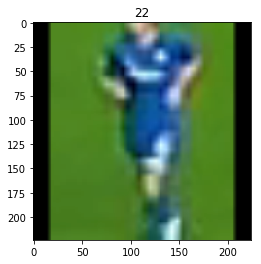

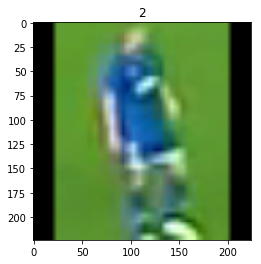

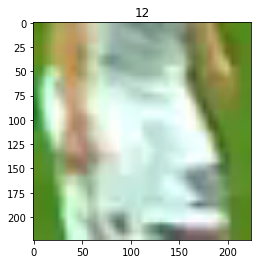

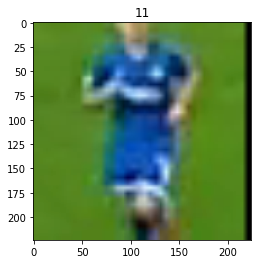

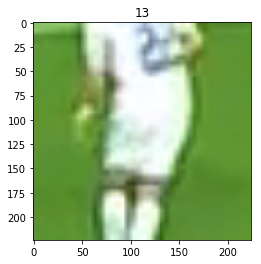

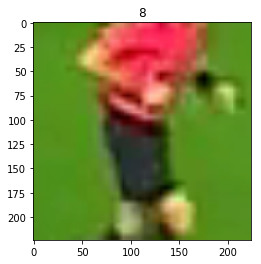

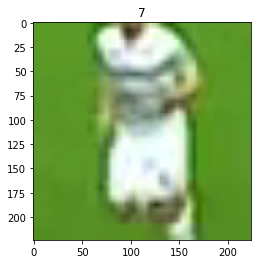

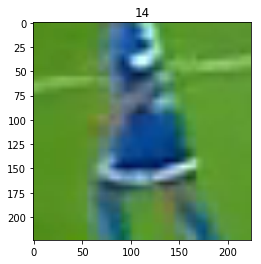

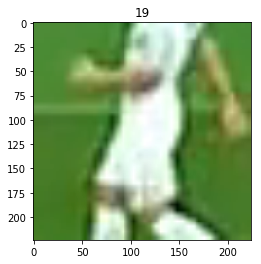

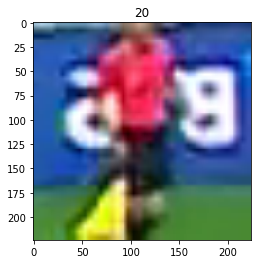

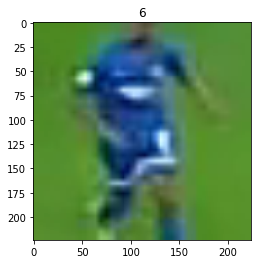

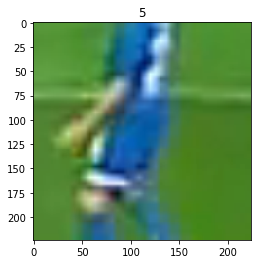

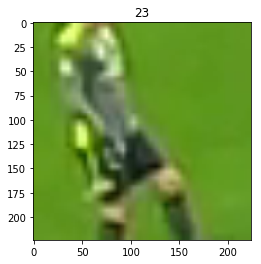

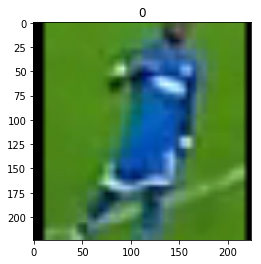

In [21]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    
    plt.imshow(image.clip(0, 1))
    plt.title(str(title.item()))
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=y_item)

In [22]:
train_accuracy_history = []
train_loss_history = []
# train_roc_auc_history = []


val_accuracy_history = []
val_loss_history = []
# val_roc_auc_history = []

res_model = None
def train_model(model, loss, optimizer, num_epochs):
    min_val_loss = 200.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.
            # running_roc_auc = 0.
            
            
            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()
                # running_roc_auc += f1_loss(labels.data, preds_class).mean()
                
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            # epoch_roc_auc = running_roc_auc / len(dataloader)
            
            if (phase == 'train'):
                train_accuracy_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
                # train_roc_auc_history.append(epoch_roc_auc)
                
            elif (phase == 'val'):
                if epoch_loss < min_val_loss:
                    min_val_loss = epoch_loss
                    with open('top_model', 'wb') as f:
                        torch.save(model, f)
                val_accuracy_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                # val_roc_auc_history.append(epoch_roc_auc)
                
            print('{} loss: {:.4f} acc: {:.4f}'.format(phase, epoch_loss, \
                                                       epoch_acc), flush=True)
    print('top model with min_val_loss:', min_val_loss)
    return 'Success'

In [23]:
model = models.resnet50(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    t = param
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 25)
# model.bn = torch.nn.BatchNorm1d(num_ftrs)
# model.fc = torch.nn.Linear(num_ftrs, int(num_ftrs / 2))
# num_ftrs = model.fc.in_features

# model.act1 = torch.nn.LeakyReLU()
# model.fc2 = torch.nn.Linear(num_ftrs, TOP_N)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3)

# Decay LR by a factor of 0.1 every 10 epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = len(train_dataloader))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 32.1MB/s]


In [24]:
train_model(model, loss, optimizer, num_epochs=150);

Epoch 0/149:


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 150/150 [00:17<00:00,  8.68it/s]

train loss: 2.5188 acc: 0.2667



100%|██████████| 38/38 [00:04<00:00,  9.42it/s]
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It

val loss: 1.8405 acc: 0.4326
Epoch 1/149:


100%|██████████| 150/150 [00:12<00:00, 11.83it/s]

train loss: 1.7943 acc: 0.4167



100%|██████████| 38/38 [00:03<00:00, 12.42it/s]


val loss: 1.5430 acc: 0.5066
Epoch 2/149:


100%|██████████| 150/150 [00:12<00:00, 11.84it/s]

train loss: 1.5223 acc: 0.5104



100%|██████████| 38/38 [00:03<00:00, 12.39it/s]


val loss: 1.4168 acc: 0.5345
Epoch 3/149:


100%|██████████| 150/150 [00:13<00:00, 11.41it/s]

train loss: 1.3948 acc: 0.5304



100%|██████████| 38/38 [00:03<00:00, 12.44it/s]

val loss: 1.4725 acc: 0.4984
Epoch 4/149:



100%|██████████| 150/150 [00:12<00:00, 12.05it/s]

train loss: 1.3363 acc: 0.5583



100%|██████████| 38/38 [00:03<00:00, 12.34it/s]

val loss: 1.4627 acc: 0.5049
Epoch 5/149:



100%|██████████| 150/150 [00:12<00:00, 11.80it/s]

train loss: 1.3228 acc: 0.5613



100%|██████████| 38/38 [00:03<00:00, 11.94it/s]


val loss: 1.3786 acc: 0.5378
Epoch 6/149:


100%|██████████| 150/150 [00:13<00:00, 11.46it/s]

train loss: 1.2236 acc: 0.5950



100%|██████████| 38/38 [00:03<00:00, 11.98it/s]


val loss: 1.2739 acc: 0.5757
Epoch 7/149:


100%|██████████| 150/150 [00:13<00:00, 11.40it/s]

train loss: 1.1668 acc: 0.6183



100%|██████████| 38/38 [00:03<00:00, 11.92it/s]


val loss: 1.2489 acc: 0.5970
Epoch 8/149:


100%|██████████| 150/150 [00:13<00:00, 11.51it/s]

train loss: 1.0883 acc: 0.6325



100%|██████████| 38/38 [00:03<00:00, 12.00it/s]

val loss: 1.2837 acc: 0.5510
Epoch 9/149:



100%|██████████| 150/150 [00:13<00:00, 11.45it/s]

train loss: 1.0699 acc: 0.6442



100%|██████████| 38/38 [00:03<00:00, 11.98it/s]

val loss: 1.2597 acc: 0.5757
Epoch 10/149:



100%|██████████| 150/150 [00:13<00:00, 11.48it/s]

train loss: 1.0844 acc: 0.6213



100%|██████████| 38/38 [00:03<00:00, 11.88it/s]

val loss: 1.2834 acc: 0.5773
Epoch 11/149:



100%|██████████| 150/150 [00:12<00:00, 11.60it/s]

train loss: 1.0081 acc: 0.6621



100%|██████████| 38/38 [00:03<00:00, 12.15it/s]

val loss: 1.2556 acc: 0.5905
Epoch 12/149:



100%|██████████| 150/150 [00:12<00:00, 11.66it/s]

train loss: 0.9932 acc: 0.6658



100%|██████████| 38/38 [00:03<00:00, 11.93it/s]

val loss: 1.2865 acc: 0.5707
Epoch 13/149:



100%|██████████| 150/150 [00:12<00:00, 11.57it/s]

train loss: 0.9661 acc: 0.6783



100%|██████████| 38/38 [00:03<00:00, 11.98it/s]


val loss: 1.2217 acc: 0.5938
Epoch 14/149:


100%|██████████| 150/150 [00:12<00:00, 11.55it/s]

train loss: 0.9279 acc: 0.6842



100%|██████████| 38/38 [00:03<00:00, 12.06it/s]

val loss: 1.2392 acc: 0.5806
Epoch 15/149:



100%|██████████| 150/150 [00:13<00:00, 11.31it/s]

train loss: 0.8929 acc: 0.6958



100%|██████████| 38/38 [00:03<00:00, 11.84it/s]


val loss: 1.1903 acc: 0.6135
Epoch 16/149:


100%|██████████| 150/150 [00:13<00:00, 11.53it/s]

train loss: 0.9025 acc: 0.6913



100%|██████████| 38/38 [00:03<00:00, 11.74it/s]

val loss: 1.2942 acc: 0.5855
Epoch 17/149:



100%|██████████| 150/150 [00:12<00:00, 11.83it/s]

train loss: 0.8960 acc: 0.6979



100%|██████████| 38/38 [00:02<00:00, 12.69it/s]

val loss: 1.1979 acc: 0.5921
Epoch 18/149:



100%|██████████| 150/150 [00:12<00:00, 12.12it/s]

train loss: 0.8861 acc: 0.7004



100%|██████████| 38/38 [00:03<00:00, 12.60it/s]

val loss: 1.2438 acc: 0.5888
Epoch 19/149:



100%|██████████| 150/150 [00:12<00:00, 12.15it/s]

train loss: 0.8541 acc: 0.7237



100%|██████████| 38/38 [00:03<00:00, 12.58it/s]

val loss: 1.2232 acc: 0.5905
Epoch 20/149:



100%|██████████| 150/150 [00:12<00:00, 12.08it/s]

train loss: 0.8583 acc: 0.7100



100%|██████████| 38/38 [00:03<00:00, 12.66it/s]

val loss: 1.3286 acc: 0.5559
Epoch 21/149:



100%|██████████| 150/150 [00:12<00:00, 12.22it/s]

train loss: 0.8720 acc: 0.7079



100%|██████████| 38/38 [00:03<00:00, 12.61it/s]

val loss: 1.2989 acc: 0.5543
Epoch 22/149:



100%|██████████| 150/150 [00:12<00:00, 11.68it/s]

train loss: 0.8070 acc: 0.7267



100%|██████████| 38/38 [00:03<00:00, 12.56it/s]

val loss: 1.2889 acc: 0.5855
Epoch 23/149:



100%|██████████| 150/150 [00:12<00:00, 12.24it/s]

train loss: 0.8602 acc: 0.7067



100%|██████████| 38/38 [00:02<00:00, 12.69it/s]

val loss: 1.3033 acc: 0.5806
Epoch 24/149:



100%|██████████| 150/150 [00:12<00:00, 12.23it/s]

train loss: 0.8415 acc: 0.7158



100%|██████████| 38/38 [00:03<00:00, 12.51it/s]

val loss: 1.2488 acc: 0.5888
Epoch 25/149:



100%|██████████| 150/150 [00:12<00:00, 12.25it/s]

train loss: 0.7745 acc: 0.7338



100%|██████████| 38/38 [00:02<00:00, 12.69it/s]

val loss: 1.2018 acc: 0.5954
Epoch 26/149:



100%|██████████| 150/150 [00:12<00:00, 12.29it/s]

train loss: 0.7740 acc: 0.7358



100%|██████████| 38/38 [00:03<00:00, 12.66it/s]

val loss: 1.2825 acc: 0.5724
Epoch 27/149:



100%|██████████| 150/150 [00:12<00:00, 12.26it/s]

train loss: 0.7689 acc: 0.7388



100%|██████████| 38/38 [00:03<00:00, 12.65it/s]

val loss: 1.2280 acc: 0.6168
Epoch 28/149:



100%|██████████| 150/150 [00:12<00:00, 12.23it/s]

train loss: 0.7488 acc: 0.7442



100%|██████████| 38/38 [00:03<00:00, 12.64it/s]

val loss: 1.2159 acc: 0.5905
Epoch 29/149:



100%|██████████| 150/150 [00:12<00:00, 12.23it/s]

train loss: 0.7522 acc: 0.7488



100%|██████████| 38/38 [00:02<00:00, 12.72it/s]

val loss: 1.2249 acc: 0.5938
Epoch 30/149:



100%|██████████| 150/150 [00:12<00:00, 12.27it/s]

train loss: 0.7239 acc: 0.7583



100%|██████████| 38/38 [00:02<00:00, 12.78it/s]


val loss: 1.1875 acc: 0.6003
Epoch 31/149:


100%|██████████| 150/150 [00:12<00:00, 12.12it/s]

train loss: 0.7519 acc: 0.7379



100%|██████████| 38/38 [00:02<00:00, 12.72it/s]

val loss: 1.2003 acc: 0.5855
Epoch 32/149:



100%|██████████| 150/150 [00:12<00:00, 12.21it/s]

train loss: 0.7408 acc: 0.7463



100%|██████████| 38/38 [00:02<00:00, 12.87it/s]

val loss: 1.2010 acc: 0.6003
Epoch 33/149:



100%|██████████| 150/150 [00:12<00:00, 12.24it/s]

train loss: 0.6974 acc: 0.7746



100%|██████████| 38/38 [00:02<00:00, 12.73it/s]


val loss: 1.1343 acc: 0.6316
Epoch 34/149:


100%|██████████| 150/150 [00:12<00:00, 12.16it/s]

train loss: 0.6984 acc: 0.7675



100%|██████████| 38/38 [00:02<00:00, 12.78it/s]

val loss: 1.2256 acc: 0.5987
Epoch 35/149:



100%|██████████| 150/150 [00:12<00:00, 12.03it/s]

train loss: 0.6993 acc: 0.7654



100%|██████████| 38/38 [00:03<00:00, 12.39it/s]

val loss: 1.1818 acc: 0.6020
Epoch 36/149:



100%|██████████| 150/150 [00:12<00:00, 12.14it/s]

train loss: 0.6953 acc: 0.7638



100%|██████████| 38/38 [00:03<00:00, 12.45it/s]

val loss: 1.1951 acc: 0.6086
Epoch 37/149:



100%|██████████| 150/150 [00:12<00:00, 12.25it/s]

train loss: 0.6963 acc: 0.7675



100%|██████████| 38/38 [00:03<00:00, 12.66it/s]


val loss: 1.1234 acc: 0.6250
Epoch 38/149:


100%|██████████| 150/150 [00:12<00:00, 12.19it/s]

train loss: 0.7028 acc: 0.7658



100%|██████████| 38/38 [00:02<00:00, 12.74it/s]

val loss: 1.2457 acc: 0.6168
Epoch 39/149:



100%|██████████| 150/150 [00:12<00:00, 12.25it/s]

train loss: 0.6707 acc: 0.7713



100%|██████████| 38/38 [00:02<00:00, 12.67it/s]

val loss: 1.1802 acc: 0.6201
Epoch 40/149:



100%|██████████| 150/150 [00:12<00:00, 12.23it/s]

train loss: 0.6699 acc: 0.7779



100%|██████████| 38/38 [00:03<00:00, 12.66it/s]

val loss: 1.2787 acc: 0.5970
Epoch 41/149:



100%|██████████| 150/150 [00:12<00:00, 12.25it/s]

train loss: 0.6420 acc: 0.7921



100%|██████████| 38/38 [00:02<00:00, 12.77it/s]

val loss: 1.1886 acc: 0.5954
Epoch 42/149:



100%|██████████| 150/150 [00:12<00:00, 11.73it/s]

train loss: 0.6649 acc: 0.7646



100%|██████████| 38/38 [00:02<00:00, 12.77it/s]

val loss: 1.1848 acc: 0.6250
Epoch 43/149:



100%|██████████| 150/150 [00:12<00:00, 12.31it/s]

train loss: 0.6418 acc: 0.7812



100%|██████████| 38/38 [00:02<00:00, 12.71it/s]

val loss: 1.1681 acc: 0.6234
Epoch 44/149:



100%|██████████| 150/150 [00:12<00:00, 12.32it/s]

train loss: 0.6534 acc: 0.7758



100%|██████████| 38/38 [00:02<00:00, 12.84it/s]

val loss: 1.1695 acc: 0.6201
Epoch 45/149:



100%|██████████| 150/150 [00:12<00:00, 12.29it/s]

train loss: 0.6427 acc: 0.7867



100%|██████████| 38/38 [00:02<00:00, 12.85it/s]

val loss: 1.1788 acc: 0.6316
Epoch 46/149:



100%|██████████| 150/150 [00:12<00:00, 12.31it/s]

train loss: 0.6122 acc: 0.7883



100%|██████████| 38/38 [00:02<00:00, 12.79it/s]

val loss: 1.1504 acc: 0.6349
Epoch 47/149:



100%|██████████| 150/150 [00:12<00:00, 12.31it/s]

train loss: 0.6044 acc: 0.7900



100%|██████████| 38/38 [00:02<00:00, 12.73it/s]

val loss: 1.1551 acc: 0.6414
Epoch 48/149:



100%|██████████| 150/150 [00:12<00:00, 12.31it/s]

train loss: 0.6260 acc: 0.7925



100%|██████████| 38/38 [00:02<00:00, 12.74it/s]

val loss: 1.2053 acc: 0.6036
Epoch 49/149:



100%|██████████| 150/150 [00:12<00:00, 12.38it/s]

train loss: 0.6197 acc: 0.7950



100%|██████████| 38/38 [00:02<00:00, 12.75it/s]

val loss: 1.1830 acc: 0.6316
Epoch 50/149:



100%|██████████| 150/150 [00:12<00:00, 12.38it/s]

train loss: 0.5894 acc: 0.8025



100%|██████████| 38/38 [00:02<00:00, 12.87it/s]

val loss: 1.2146 acc: 0.6184
Epoch 51/149:



100%|██████████| 150/150 [00:12<00:00, 12.39it/s]

train loss: 0.6050 acc: 0.7979



100%|██████████| 38/38 [00:02<00:00, 12.84it/s]

val loss: 1.1508 acc: 0.6365
Epoch 52/149:



100%|██████████| 150/150 [00:12<00:00, 12.34it/s]

train loss: 0.6142 acc: 0.7933



100%|██████████| 38/38 [00:02<00:00, 12.91it/s]

val loss: 1.1468 acc: 0.6447
Epoch 53/149:



100%|██████████| 150/150 [00:12<00:00, 12.36it/s]

train loss: 0.5984 acc: 0.7996



100%|██████████| 38/38 [00:02<00:00, 12.74it/s]

val loss: 1.1541 acc: 0.6184
Epoch 54/149:



100%|██████████| 150/150 [00:12<00:00, 12.38it/s]

train loss: 0.5877 acc: 0.7979



100%|██████████| 38/38 [00:02<00:00, 12.92it/s]

val loss: 1.2024 acc: 0.6332
Epoch 55/149:



100%|██████████| 150/150 [00:12<00:00, 12.24it/s]

train loss: 0.5971 acc: 0.8008



100%|██████████| 38/38 [00:03<00:00, 12.40it/s]

val loss: 1.1632 acc: 0.6217
Epoch 56/149:



100%|██████████| 150/150 [00:12<00:00, 12.12it/s]

train loss: 0.5742 acc: 0.8117



100%|██████████| 38/38 [00:03<00:00, 12.47it/s]

val loss: 1.1639 acc: 0.6365
Epoch 57/149:



100%|██████████| 150/150 [00:12<00:00, 12.39it/s]

train loss: 0.5972 acc: 0.8042



100%|██████████| 38/38 [00:02<00:00, 12.84it/s]

val loss: 1.1462 acc: 0.6398
Epoch 58/149:



100%|██████████| 150/150 [00:12<00:00, 12.39it/s]

train loss: 0.5677 acc: 0.8154



100%|██████████| 38/38 [00:02<00:00, 12.73it/s]

val loss: 1.1405 acc: 0.6365
Epoch 59/149:



100%|██████████| 150/150 [00:12<00:00, 12.42it/s]

train loss: 0.5711 acc: 0.8100



100%|██████████| 38/38 [00:02<00:00, 12.91it/s]

val loss: 1.1907 acc: 0.6349
Epoch 60/149:



100%|██████████| 150/150 [00:12<00:00, 12.40it/s]

train loss: 0.5755 acc: 0.8075



100%|██████████| 38/38 [00:02<00:00, 12.80it/s]

val loss: 1.1921 acc: 0.6447
Epoch 61/149:



100%|██████████| 150/150 [00:12<00:00, 12.36it/s]

train loss: 0.5559 acc: 0.8150



100%|██████████| 38/38 [00:02<00:00, 12.81it/s]

val loss: 1.1332 acc: 0.6365
Epoch 62/149:



100%|██████████| 150/150 [00:12<00:00, 11.82it/s]

train loss: 0.5568 acc: 0.8188



100%|██████████| 38/38 [00:02<00:00, 12.74it/s]

val loss: 1.1340 acc: 0.6349
Epoch 63/149:



100%|██████████| 150/150 [00:12<00:00, 12.39it/s]

train loss: 0.5548 acc: 0.8179



100%|██████████| 38/38 [00:02<00:00, 12.73it/s]

val loss: 1.2052 acc: 0.6365
Epoch 64/149:



100%|██████████| 150/150 [00:12<00:00, 12.34it/s]

train loss: 0.5341 acc: 0.8238



100%|██████████| 38/38 [00:02<00:00, 12.73it/s]

val loss: 1.1992 acc: 0.6135
Epoch 65/149:



100%|██████████| 150/150 [00:12<00:00, 12.39it/s]

train loss: 0.5395 acc: 0.8188



100%|██████████| 38/38 [00:02<00:00, 12.75it/s]

val loss: 1.1490 acc: 0.6184
Epoch 66/149:



100%|██████████| 150/150 [00:12<00:00, 12.39it/s]

train loss: 0.5364 acc: 0.8279



100%|██████████| 38/38 [00:02<00:00, 12.78it/s]

val loss: 1.2033 acc: 0.6349
Epoch 67/149:



100%|██████████| 150/150 [00:12<00:00, 12.44it/s]

train loss: 0.5244 acc: 0.8292



100%|██████████| 38/38 [00:02<00:00, 12.77it/s]

val loss: 1.1849 acc: 0.6283
Epoch 68/149:



100%|██████████| 150/150 [00:12<00:00, 12.40it/s]

train loss: 0.5590 acc: 0.8088



100%|██████████| 38/38 [00:02<00:00, 12.74it/s]

val loss: 1.1390 acc: 0.6168
Epoch 69/149:



100%|██████████| 150/150 [00:12<00:00, 12.41it/s]

train loss: 0.5197 acc: 0.8313



100%|██████████| 38/38 [00:02<00:00, 12.91it/s]

val loss: 1.1600 acc: 0.6184
Epoch 70/149:



100%|██████████| 150/150 [00:12<00:00, 12.42it/s]

train loss: 0.5195 acc: 0.8271



100%|██████████| 38/38 [00:02<00:00, 12.77it/s]

val loss: 1.2163 acc: 0.6184
Epoch 71/149:



100%|██████████| 150/150 [00:12<00:00, 12.47it/s]

train loss: 0.5195 acc: 0.8342



100%|██████████| 38/38 [00:02<00:00, 12.77it/s]

val loss: 1.2015 acc: 0.6135
Epoch 72/149:



100%|██████████| 150/150 [00:12<00:00, 12.32it/s]

train loss: 0.5174 acc: 0.8313



100%|██████████| 38/38 [00:02<00:00, 12.93it/s]

val loss: 1.1449 acc: 0.6168
Epoch 73/149:



100%|██████████| 150/150 [00:12<00:00, 12.45it/s]

train loss: 0.5042 acc: 0.8329



100%|██████████| 38/38 [00:02<00:00, 12.88it/s]

val loss: 1.1908 acc: 0.6053
Epoch 74/149:



100%|██████████| 150/150 [00:12<00:00, 12.48it/s]

train loss: 0.5223 acc: 0.8338



100%|██████████| 38/38 [00:02<00:00, 12.99it/s]

val loss: 1.1354 acc: 0.6332
Epoch 75/149:



100%|██████████| 150/150 [00:12<00:00, 12.46it/s]

train loss: 0.4880 acc: 0.8446



100%|██████████| 38/38 [00:02<00:00, 12.82it/s]


val loss: 1.1222 acc: 0.6250
Epoch 76/149:


100%|██████████| 150/150 [00:12<00:00, 12.00it/s]

train loss: 0.5141 acc: 0.8308



100%|██████████| 38/38 [00:03<00:00, 12.60it/s]

val loss: 1.1284 acc: 0.6349
Epoch 77/149:



100%|██████████| 150/150 [00:12<00:00, 12.30it/s]

train loss: 0.4986 acc: 0.8413



100%|██████████| 38/38 [00:02<00:00, 12.81it/s]


val loss: 1.0776 acc: 0.6513
Epoch 78/149:


100%|██████████| 150/150 [00:12<00:00, 12.27it/s]

train loss: 0.5167 acc: 0.8317



100%|██████████| 38/38 [00:02<00:00, 12.88it/s]

val loss: 1.1322 acc: 0.6414
Epoch 79/149:



100%|██████████| 150/150 [00:12<00:00, 12.41it/s]

train loss: 0.4803 acc: 0.8512



100%|██████████| 38/38 [00:02<00:00, 12.89it/s]

val loss: 1.1483 acc: 0.6349
Epoch 80/149:



100%|██████████| 150/150 [00:12<00:00, 12.43it/s]

train loss: 0.5125 acc: 0.8346



100%|██████████| 38/38 [00:02<00:00, 12.85it/s]

val loss: 1.1368 acc: 0.6316
Epoch 81/149:



100%|██████████| 150/150 [00:12<00:00, 12.39it/s]

train loss: 0.4899 acc: 0.8442



100%|██████████| 38/38 [00:02<00:00, 12.99it/s]

val loss: 1.1681 acc: 0.6266
Epoch 82/149:



100%|██████████| 150/150 [00:12<00:00, 11.78it/s]

train loss: 0.4996 acc: 0.8442



100%|██████████| 38/38 [00:02<00:00, 12.92it/s]

val loss: 1.0993 acc: 0.6480
Epoch 83/149:



100%|██████████| 150/150 [00:12<00:00, 12.39it/s]

train loss: 0.4947 acc: 0.8396



100%|██████████| 38/38 [00:02<00:00, 12.75it/s]

val loss: 1.1468 acc: 0.6316
Epoch 84/149:



100%|██████████| 150/150 [00:12<00:00, 12.36it/s]

train loss: 0.5048 acc: 0.8321



100%|██████████| 38/38 [00:02<00:00, 12.83it/s]

val loss: 1.1873 acc: 0.6234
Epoch 85/149:



100%|██████████| 150/150 [00:12<00:00, 12.40it/s]

train loss: 0.5034 acc: 0.8342



100%|██████████| 38/38 [00:03<00:00, 12.65it/s]

val loss: 1.1550 acc: 0.6168
Epoch 86/149:



100%|██████████| 150/150 [00:12<00:00, 12.34it/s]

train loss: 0.4973 acc: 0.8358



100%|██████████| 38/38 [00:02<00:00, 12.82it/s]

val loss: 1.1391 acc: 0.6316
Epoch 87/149:



100%|██████████| 150/150 [00:12<00:00, 12.34it/s]

train loss: 0.4764 acc: 0.8533



100%|██████████| 38/38 [00:02<00:00, 12.86it/s]

val loss: 1.1377 acc: 0.6299
Epoch 88/149:



100%|██████████| 150/150 [00:12<00:00, 12.42it/s]

train loss: 0.4679 acc: 0.8517



100%|██████████| 38/38 [00:03<00:00, 12.55it/s]

val loss: 1.1092 acc: 0.6365
Epoch 89/149:



100%|██████████| 150/150 [00:12<00:00, 12.16it/s]

train loss: 0.4893 acc: 0.8450



100%|██████████| 38/38 [00:02<00:00, 12.71it/s]

val loss: 1.1202 acc: 0.6595
Epoch 90/149:



100%|██████████| 150/150 [00:12<00:00, 12.28it/s]

train loss: 0.4691 acc: 0.8521



100%|██████████| 38/38 [00:02<00:00, 12.80it/s]

val loss: 1.1230 acc: 0.6365
Epoch 91/149:



100%|██████████| 150/150 [00:12<00:00, 12.33it/s]

train loss: 0.4739 acc: 0.8554



100%|██████████| 38/38 [00:03<00:00, 12.62it/s]

val loss: 1.1994 acc: 0.6184
Epoch 92/149:



100%|██████████| 150/150 [00:12<00:00, 12.31it/s]

train loss: 0.4691 acc: 0.8567



100%|██████████| 38/38 [00:02<00:00, 12.71it/s]

val loss: 1.1269 acc: 0.6151
Epoch 93/149:



100%|██████████| 150/150 [00:12<00:00, 12.32it/s]

train loss: 0.4665 acc: 0.8508



100%|██████████| 38/38 [00:02<00:00, 12.76it/s]

val loss: 1.1092 acc: 0.6382
Epoch 94/149:



100%|██████████| 150/150 [00:12<00:00, 12.45it/s]

train loss: 0.4737 acc: 0.8492



100%|██████████| 38/38 [00:02<00:00, 12.81it/s]

val loss: 1.1067 acc: 0.6118
Epoch 95/149:



100%|██████████| 150/150 [00:12<00:00, 12.39it/s]

train loss: 0.4716 acc: 0.8558



100%|██████████| 38/38 [00:02<00:00, 12.70it/s]

val loss: 1.1303 acc: 0.6299
Epoch 96/149:



100%|██████████| 150/150 [00:12<00:00, 12.32it/s]

train loss: 0.4684 acc: 0.8546



100%|██████████| 38/38 [00:03<00:00, 12.39it/s]

val loss: 1.1351 acc: 0.6480
Epoch 97/149:



100%|██████████| 150/150 [00:12<00:00, 12.18it/s]

train loss: 0.4685 acc: 0.8600



100%|██████████| 38/38 [00:02<00:00, 13.01it/s]

val loss: 1.1504 acc: 0.6299
Epoch 98/149:



100%|██████████| 150/150 [00:12<00:00, 12.38it/s]

train loss: 0.4381 acc: 0.8783



100%|██████████| 38/38 [00:02<00:00, 12.87it/s]

val loss: 1.1050 acc: 0.6365
Epoch 99/149:



100%|██████████| 150/150 [00:12<00:00, 12.35it/s]

train loss: 0.4705 acc: 0.8546



100%|██████████| 38/38 [00:02<00:00, 12.68it/s]

val loss: 1.1222 acc: 0.6349
Epoch 100/149:



100%|██████████| 150/150 [00:12<00:00, 12.41it/s]

train loss: 0.4454 acc: 0.8688



100%|██████████| 38/38 [00:02<00:00, 12.88it/s]

val loss: 1.1190 acc: 0.6283
Epoch 101/149:



100%|██████████| 150/150 [00:12<00:00, 12.43it/s]

train loss: 0.4357 acc: 0.8683



100%|██████████| 38/38 [00:02<00:00, 12.91it/s]

val loss: 1.1653 acc: 0.6349
Epoch 102/149:



100%|██████████| 150/150 [00:12<00:00, 11.89it/s]

train loss: 0.4498 acc: 0.8600



100%|██████████| 38/38 [00:02<00:00, 12.93it/s]

val loss: 1.1411 acc: 0.6349
Epoch 103/149:



100%|██████████| 150/150 [00:12<00:00, 12.38it/s]

train loss: 0.4807 acc: 0.8500



100%|██████████| 38/38 [00:02<00:00, 12.83it/s]

val loss: 1.1610 acc: 0.6184
Epoch 104/149:



100%|██████████| 150/150 [00:12<00:00, 12.37it/s]

train loss: 0.4488 acc: 0.8567



100%|██████████| 38/38 [00:02<00:00, 12.89it/s]

val loss: 1.1324 acc: 0.6464
Epoch 105/149:



100%|██████████| 150/150 [00:12<00:00, 12.38it/s]

train loss: 0.4548 acc: 0.8579



100%|██████████| 38/38 [00:02<00:00, 12.92it/s]

val loss: 1.1153 acc: 0.6332
Epoch 106/149:



100%|██████████| 150/150 [00:12<00:00, 12.41it/s]

train loss: 0.4443 acc: 0.8625



100%|██████████| 38/38 [00:02<00:00, 12.82it/s]

val loss: 1.0899 acc: 0.6447
Epoch 107/149:



100%|██████████| 150/150 [00:12<00:00, 12.39it/s]

train loss: 0.4720 acc: 0.8583



100%|██████████| 38/38 [00:02<00:00, 12.91it/s]

val loss: 1.1309 acc: 0.6316
Epoch 108/149:



100%|██████████| 150/150 [00:12<00:00, 12.41it/s]

train loss: 0.4582 acc: 0.8571



100%|██████████| 38/38 [00:02<00:00, 13.03it/s]


val loss: 1.0222 acc: 0.6678
Epoch 109/149:


100%|██████████| 150/150 [00:12<00:00, 12.36it/s]

train loss: 0.4191 acc: 0.8729



100%|██████████| 38/38 [00:02<00:00, 12.93it/s]

val loss: 1.1521 acc: 0.6365
Epoch 110/149:



100%|██████████| 150/150 [00:12<00:00, 12.43it/s]

train loss: 0.4523 acc: 0.8625



100%|██████████| 38/38 [00:02<00:00, 12.93it/s]

val loss: 1.1598 acc: 0.6480
Epoch 111/149:



100%|██████████| 150/150 [00:12<00:00, 12.33it/s]

train loss: 0.4686 acc: 0.8588



100%|██████████| 38/38 [00:02<00:00, 12.87it/s]

val loss: 1.0697 acc: 0.6266
Epoch 112/149:



100%|██████████| 150/150 [00:12<00:00, 12.42it/s]

train loss: 0.4337 acc: 0.8742



100%|██████████| 38/38 [00:02<00:00, 12.93it/s]

val loss: 1.0651 acc: 0.6628
Epoch 113/149:



100%|██████████| 150/150 [00:12<00:00, 12.42it/s]

train loss: 0.4139 acc: 0.8750



100%|██████████| 38/38 [00:02<00:00, 12.99it/s]

val loss: 1.0785 acc: 0.6546
Epoch 114/149:



100%|██████████| 150/150 [00:12<00:00, 12.47it/s]

train loss: 0.4225 acc: 0.8729



100%|██████████| 38/38 [00:02<00:00, 12.90it/s]

val loss: 1.1218 acc: 0.6234
Epoch 115/149:



100%|██████████| 150/150 [00:12<00:00, 12.40it/s]

train loss: 0.4438 acc: 0.8708



100%|██████████| 38/38 [00:02<00:00, 12.79it/s]

val loss: 1.0723 acc: 0.6530
Epoch 116/149:



100%|██████████| 150/150 [00:12<00:00, 12.40it/s]

train loss: 0.4417 acc: 0.8592



100%|██████████| 38/38 [00:02<00:00, 12.77it/s]

val loss: 1.0598 acc: 0.6447
Epoch 117/149:



100%|██████████| 150/150 [00:12<00:00, 11.97it/s]

train loss: 0.4400 acc: 0.8704



100%|██████████| 38/38 [00:02<00:00, 12.89it/s]

val loss: 1.1355 acc: 0.6562
Epoch 118/149:



100%|██████████| 150/150 [00:12<00:00, 12.38it/s]

train loss: 0.4294 acc: 0.8688



100%|██████████| 38/38 [00:03<00:00, 12.54it/s]

val loss: 1.1326 acc: 0.6497
Epoch 119/149:



100%|██████████| 150/150 [00:12<00:00, 12.38it/s]

train loss: 0.4201 acc: 0.8733



100%|██████████| 38/38 [00:02<00:00, 12.82it/s]

val loss: 1.0915 acc: 0.6414
Epoch 120/149:



100%|██████████| 150/150 [00:12<00:00, 12.37it/s]

train loss: 0.4551 acc: 0.8558



100%|██████████| 38/38 [00:02<00:00, 12.92it/s]

val loss: 1.1403 acc: 0.6431
Epoch 121/149:



100%|██████████| 150/150 [00:12<00:00, 12.31it/s]

train loss: 0.4294 acc: 0.8692



100%|██████████| 38/38 [00:03<00:00, 12.53it/s]

val loss: 1.1036 acc: 0.6299
Epoch 122/149:



100%|██████████| 150/150 [00:13<00:00, 11.46it/s]

train loss: 0.4166 acc: 0.8713



100%|██████████| 38/38 [00:03<00:00, 12.48it/s]

val loss: 1.1235 acc: 0.6414
Epoch 123/149:



100%|██████████| 150/150 [00:12<00:00, 12.14it/s]

train loss: 0.4323 acc: 0.8654



100%|██████████| 38/38 [00:03<00:00, 12.51it/s]

val loss: 1.1377 acc: 0.6234
Epoch 124/149:



100%|██████████| 150/150 [00:12<00:00, 12.14it/s]

train loss: 0.4304 acc: 0.8800



100%|██████████| 38/38 [00:03<00:00, 12.58it/s]

val loss: 1.1305 acc: 0.6414
Epoch 125/149:



100%|██████████| 150/150 [00:12<00:00, 12.07it/s]

train loss: 0.4233 acc: 0.8808



100%|██████████| 38/38 [00:03<00:00, 12.54it/s]

val loss: 1.1145 acc: 0.6431
Epoch 126/149:



100%|██████████| 150/150 [00:12<00:00, 12.00it/s]

train loss: 0.4286 acc: 0.8704



100%|██████████| 38/38 [00:03<00:00, 12.58it/s]

val loss: 1.1343 acc: 0.6382
Epoch 127/149:



100%|██████████| 150/150 [00:12<00:00, 12.10it/s]

train loss: 0.4386 acc: 0.8646



100%|██████████| 38/38 [00:03<00:00, 12.63it/s]

val loss: 1.1155 acc: 0.6447
Epoch 128/149:



100%|██████████| 150/150 [00:12<00:00, 12.24it/s]

train loss: 0.4478 acc: 0.8592



100%|██████████| 38/38 [00:02<00:00, 12.80it/s]

val loss: 1.0926 acc: 0.6497
Epoch 129/149:



100%|██████████| 150/150 [00:12<00:00, 12.32it/s]

train loss: 0.4259 acc: 0.8771



100%|██████████| 38/38 [00:03<00:00, 12.52it/s]

val loss: 1.0791 acc: 0.6365
Epoch 130/149:



100%|██████████| 150/150 [00:12<00:00, 12.32it/s]

train loss: 0.4270 acc: 0.8733



100%|██████████| 38/38 [00:03<00:00, 12.60it/s]

val loss: 1.1182 acc: 0.6480
Epoch 131/149:



100%|██████████| 150/150 [00:12<00:00, 12.17it/s]

train loss: 0.4339 acc: 0.8679



100%|██████████| 38/38 [00:03<00:00, 12.46it/s]

val loss: 1.1418 acc: 0.6382
Epoch 132/149:



100%|██████████| 150/150 [00:12<00:00, 12.21it/s]

train loss: 0.4360 acc: 0.8721



100%|██████████| 38/38 [00:03<00:00, 12.52it/s]

val loss: 1.0794 acc: 0.6628
Epoch 133/149:



100%|██████████| 150/150 [00:12<00:00, 12.10it/s]

train loss: 0.4274 acc: 0.8733



100%|██████████| 38/38 [00:03<00:00, 12.34it/s]

val loss: 1.1455 acc: 0.6382
Epoch 134/149:



100%|██████████| 150/150 [00:12<00:00, 12.30it/s]

train loss: 0.4130 acc: 0.8821



100%|██████████| 38/38 [00:03<00:00, 12.60it/s]

val loss: 1.0858 acc: 0.6513
Epoch 135/149:



100%|██████████| 150/150 [00:12<00:00, 12.39it/s]

train loss: 0.4075 acc: 0.8821



100%|██████████| 38/38 [00:02<00:00, 12.84it/s]

val loss: 1.1087 acc: 0.6464
Epoch 136/149:



100%|██████████| 150/150 [00:12<00:00, 12.42it/s]

train loss: 0.4213 acc: 0.8671



100%|██████████| 38/38 [00:02<00:00, 12.86it/s]

val loss: 1.1181 acc: 0.6497
Epoch 137/149:



100%|██████████| 150/150 [00:12<00:00, 12.06it/s]

train loss: 0.4368 acc: 0.8654



100%|██████████| 38/38 [00:03<00:00, 12.42it/s]

val loss: 1.0703 acc: 0.6480
Epoch 138/149:



100%|██████████| 150/150 [00:12<00:00, 12.40it/s]

train loss: 0.4291 acc: 0.8738



100%|██████████| 38/38 [00:02<00:00, 12.91it/s]

val loss: 1.0749 acc: 0.6678
Epoch 139/149:



100%|██████████| 150/150 [00:12<00:00, 12.48it/s]

train loss: 0.4177 acc: 0.8808



100%|██████████| 38/38 [00:02<00:00, 12.85it/s]

val loss: 1.1730 acc: 0.6234
Epoch 140/149:



100%|██████████| 150/150 [00:12<00:00, 12.45it/s]

train loss: 0.4280 acc: 0.8763



100%|██████████| 38/38 [00:02<00:00, 12.93it/s]

val loss: 1.1271 acc: 0.6497
Epoch 141/149:



100%|██████████| 150/150 [00:11<00:00, 12.52it/s]

train loss: 0.4119 acc: 0.8829



100%|██████████| 38/38 [00:02<00:00, 12.89it/s]

val loss: 1.1198 acc: 0.6349
Epoch 142/149:



100%|██████████| 150/150 [00:12<00:00, 11.80it/s]

train loss: 0.4272 acc: 0.8704



100%|██████████| 38/38 [00:03<00:00, 12.63it/s]

val loss: 1.1355 acc: 0.6431
Epoch 143/149:



100%|██████████| 150/150 [00:12<00:00, 12.24it/s]

train loss: 0.4206 acc: 0.8754



100%|██████████| 38/38 [00:03<00:00, 12.54it/s]

val loss: 1.1158 acc: 0.6546
Epoch 144/149:



100%|██████████| 150/150 [00:12<00:00, 12.16it/s]

train loss: 0.4339 acc: 0.8708



100%|██████████| 38/38 [00:02<00:00, 12.72it/s]

val loss: 1.1070 acc: 0.6464
Epoch 145/149:



100%|██████████| 150/150 [00:12<00:00, 12.29it/s]

train loss: 0.4103 acc: 0.8796



100%|██████████| 38/38 [00:02<00:00, 12.75it/s]

val loss: 1.1304 acc: 0.6382
Epoch 146/149:



100%|██████████| 150/150 [00:12<00:00, 12.18it/s]

train loss: 0.4428 acc: 0.8638



100%|██████████| 38/38 [00:03<00:00, 12.48it/s]

val loss: 1.0955 acc: 0.6382
Epoch 147/149:



100%|██████████| 150/150 [00:12<00:00, 12.15it/s]

train loss: 0.4461 acc: 0.8600



100%|██████████| 38/38 [00:02<00:00, 12.72it/s]

val loss: 1.1027 acc: 0.6562
Epoch 148/149:



100%|██████████| 150/150 [00:12<00:00, 12.27it/s]

train loss: 0.4102 acc: 0.8817



100%|██████████| 38/38 [00:02<00:00, 12.89it/s]

val loss: 1.1415 acc: 0.6234
Epoch 149/149:



100%|██████████| 150/150 [00:12<00:00, 12.35it/s]

train loss: 0.4129 acc: 0.8813



100%|██████████| 38/38 [00:03<00:00, 12.55it/s]

val loss: 1.1067 acc: 0.6299
top model with min_val_loss: 1.0221689915970753


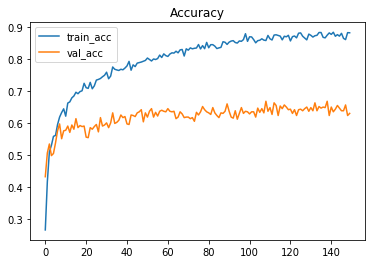

In [25]:
plt.plot(train_accuracy_history, label='train_acc')
plt.plot(val_accuracy_history, label='val_acc')
plt.legend()
plt.title('Accuracy');

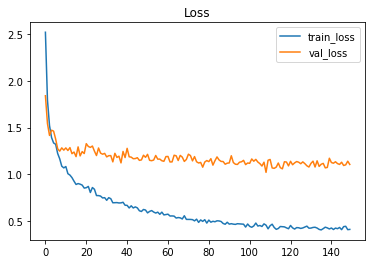

In [26]:
plt.plot(train_loss_history, label='train_loss')
plt.plot(val_loss_history, label='val_loss')
plt.legend()
plt.title('Loss');

In [27]:
# initialize our dataset at first
dataset = ImagesDataset(
    df = test_df,
    transform = val_transforms
)

test_dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size)

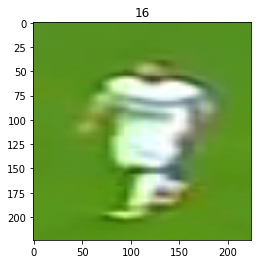

In [28]:
X_batch, y_batch = next(iter(test_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);
plt.title(int(y_batch[0]))
plt.show()

In [29]:
# Load the best saved model.
with open('top_model', 'rb') as f:
    model = torch.load(f)
model.eval()

test_labels = []
test_predictions = []
test_predictions_class = []
test_batch_loss = 0.0
test_batch_acc = 0.0

for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.to(device)
    for element in labels:
        test_labels.append(int(element))
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
        loss_value = loss(preds, labels)
        preds_class = preds.argmax(dim=1)
        for element in preds_class:
            test_predictions_class.append(int(element))
    test_batch_loss += loss_value.item()
    test_batch_acc += (preds_class == labels.data).float().mean()
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    
test_predictions = np.concatenate(test_predictions)

test_loss = test_batch_loss / len(test_dataloader)
test_acc = test_batch_acc / len(test_dataloader)

100%|██████████| 47/47 [00:05<00:00,  9.02it/s]


In [30]:
print('test_loss:', test_loss)
print('test_acc:', float(test_acc))

test_loss: 2.474744185488275
test_acc: 0.3957066833972931
